In [2]:
# ============================================================
# 1. Install DeepXDE (run once in Colab)
# ============================================================
!pip install deepxde


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.4 MB/s eta 0:00:00


In [3]:

# ============================================================
# 2. Select backend (TensorFlow 2 is default in Colab)
#    Supported: tensorflow.compat.v1, tensorflow, pytorch, paddle
# ============================================================
import deepxde as dde
import numpy as np

dde.backend.set_default_backend("tensorflow")


No backend selected.
Finding available backend...
Found tensorflow
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Setting the default backend to "tensorflow". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [4]:

# ============================================================
# 3. Define the ODE
#    y'' - 10 y' + 9 y = 5 t
# ============================================================
def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return d2y_dt2 - 10 * dy_dt + 9 * y - 5 * t


In [5]:

# ============================================================
# 4. Exact solution (for error evaluation)
# ============================================================
def func(t):
    return 50 / 81 + t * 5 / 9 - 2 * np.exp(t) + (31 / 81) * np.exp(9 * t)


In [6]:

# ============================================================
# 5. Time domain
# ============================================================
geom = dde.geometry.TimeDomain(0.0, 0.25)


In [7]:

# ============================================================
# 6. Initial conditions
#    y(0) = -1
#    y'(0) = 2
# ============================================================
def boundary_l(t, on_initial):
    return on_initial and dde.utils.isclose(t[0], 0.0)

# y(0) = -1
ic1 = dde.icbc.IC(
    geom,
    lambda x: -1,
    lambda _, on_initial: on_initial,
)

# y'(0) = 2
def bc_func2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs) - 2

ic2 = dde.icbc.OperatorBC(geom, bc_func2, boundary_l)


In [8]:

# ============================================================
# 7. Training data
# ============================================================
data = dde.data.TimePDE(
    geom,
    ode,
    [ic1, ic2],
    num_domain=16,
    num_boundary=2,
    solution=func,
    num_test=500,
)


In [9]:

# ============================================================
# 8. Neural network
# ============================================================
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"

net = dde.nn.FNN(layer_size, activation, initializer)


In [10]:

# ============================================================
# 9. Model compilation
# ============================================================
model = dde.Model(data, net)
model.compile(
    optimizer="adam",
    lr=0.001,
    metrics=["l2 relative error"],
    loss_weights=[0.01, 1, 1],
)


Compiling model...
'compile' took 0.064714 s



In [11]:

# ============================================================
# 10. Train
# ============================================================
losshistory, train_state = model.train(iterations=10000)


Training model...



Cause: could not parse the source code of <function <lambda> at 0x7b89576fa020>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7b89576fa020>: no matching AST found among candidates:
# coding=utf-8
lambda x, on: np.array([on_boundary(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary1(x[i], on[i]) for i in range(len(x))])
# coding=utf-8
lambda x, on: np.array([on_boundary2(x[i], on[i]) for i in range(len(x))])
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Step      Train loss                        Test loss                         Test metric   
0         [1.96e-01, 1.00e+00, 2.47e+00]    [1.97e-01, 1.00e+00, 2.47e+00]    [9.79e-01]    
1000      [1.11e+00, 8.65e-01, 8.85e-01]    [1.06e+00, 8.65e-01, 8.85e-01]    [9.45e-01]    
2000      [1.33e-03, 1.68e-06, 3.19e-06]    [1.29e-03, 1.68e-06, 3.19e-06]    [2.47e-03]    
3000      [2.62e-04, 1.16e-06, 4.34e-05]    [2.98e-04, 1.16e-06, 4.34e-05]    [7.29e-04]    
4000      [3.57e-05, 5.88e-09, 1.04e-09]    [3.91e-

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


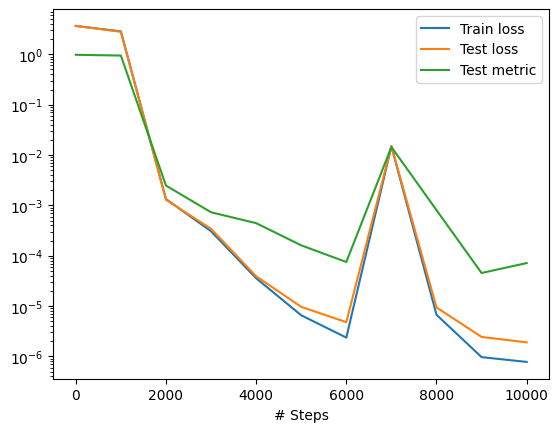

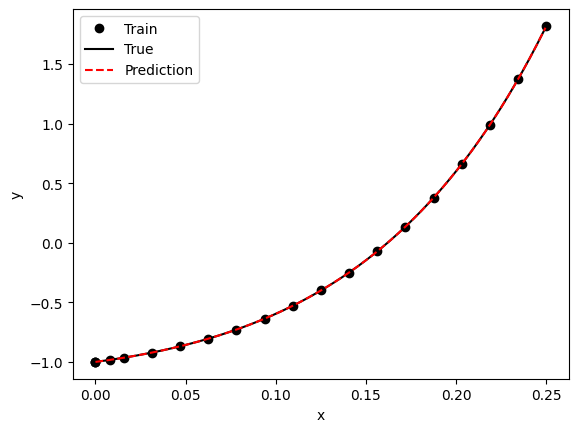

In [12]:

# ============================================================
# 11. Save and plot results
# ============================================================
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
